In [1]:
import numpy as np
import pandas as pd

from quantopian.research import run_pipeline


from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.filters import default_us_equity_universe_mask

from quantopian.pipeline.data.sentdex import sentiment_free as sentdex
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.zacks import EarningsSurprises

import datetime
from time import time
from datetime import datetime, timedelta

import alphalens as al


In [2]:
# Set Parameters

In [3]:
periods = (21, 62, 252)
quantiles = 5
#sectors = results["Sector"]
max_loss = .999

start_date = "2004-01-01"
end_date = "2005-01-01"
start = start_date
end = "2006-12-01"


In [4]:


MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

as_ = morningstar.asset_classification
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_ratios
v = morningstar.valuation
vr = morningstar.valuation_ratios



In [5]:
# Create Pipeline

In [6]:

def make_pipeline():
    
    #universe = QTradableStocksUS()
    universe = (default_us_equity_universe_mask(minimum_market_cap=25000000)) 


    
    # Morningstar ratios
    #financial_health_grade = as_.financial_health_grade.latest
    growth_score = as_.growth_score.latest.rank(mask = universe, method = "average", ascending= True)
    value_score = as_.value_score.latest.rank(mask = universe, method = "average", ascending= True)
    
    # Valuation ratios
    market_cap = (v.market_cap.latest/1000000).rank(mask = universe, method = "average", ascending= False)
    cash_return = vr.cash_return.latest.rank(mask = universe, method = "average", ascending= True)
    cf_yield = vr.cf_yield.latest.rank(mask = universe, method = "average", ascending= True)
    earning_yield = vr.earning_yield.latest.rank(mask = universe, method = "average", ascending= True)
    ev_to_ebitda = vr.ev_to_ebitda.latest.rank(mask = universe, method = "average", ascending= False)
    pb_ratio = vr.pb_ratio.latest.rank(mask = universe, method = "average", ascending= False)     
    pe_ratio = vr.pe_ratio.latest.rank(mask = universe, method = "average", ascending= False)
    peg_ratio = vr.peg_ratio.latest.rank(mask = universe, method = "average", ascending= False)
    ps_ratio = vr.ps_ratio.latest.rank(mask = universe, method = "average", ascending= False)            
    pcf_ratio = vr.pcf_ratio.latest.rank(mask = universe, method = "average", ascending= False)
    total_yield = vr.total_yield.latest.rank(mask = universe, method = "average", ascending= True)


    # Operation ratios
    ltbe_ratio = or_.long_term_debt_equity_ratio.latest.rank(mask = universe, method = "average", ascending= False)
    current_ratio = or_.current_ratio.latest.rank(mask = universe, method = "average", ascending= True)
    interest_coverage = or_.interest_coverage.latest.rank(mask = universe, method = "average", ascending= True)
    assets_turnover = or_.assets_turnover.latest.rank(mask = universe, method = "average", ascending= True)
    cash_conversion_cycle = or_.cash_conversion_cycle.latest.rank(mask = universe, method = "average", ascending= False)
    days_in_sales = or_.days_in_sales.latest.rank(mask = universe, method = "average", ascending= False)
    net_income_growth = or_.net_income_growth.latest.rank(mask = universe, method = "average", ascending= True)
    sales_per_employee = or_.sales_per_employee.latest.rank(mask = universe, method = "average", ascending= True)
    revenue_growth = or_.revenue_growth.latest.rank(mask = universe, method = "average", ascending= True)
    dps_growth = er.dps_growth.latest.rank(mask = universe, method = "average", ascending= True)
    
    
    # Margins
    ebit_margin = or_.ebit_margin.latest.rank(mask = universe, method = "average", ascending= True)
    gross_margin = or_.gross_margin.latest.rank(mask = universe, method = "average", ascending= True)
    operation_margin = or_.operation_margin.latest.rank(mask = universe, method = "average", ascending= True)
    net_margin = or_.net_margin.latest.rank(mask = universe, method = "average", ascending= True)

    # Returns
    roa = or_.roa.latest.rank(mask = universe, method = "average", ascending= True)        
    roe = or_.roe.latest.rank(mask = universe, method = "average", ascending= True)
    roic = or_.roic.latest.rank(mask = universe, method = "average", ascending= True)

    
    #testing_factor = Fundamentals.revenue_growth.latest
    
    
    
    # Altmann
    total_non_current_assets = bs.total_non_current_assets.latest
    total_assets = bs.total_assets.latest   
    total_debt_equity_ratio = or_.total_debt_equity_ratio.latest
    total_equity = bs.total_equity.latest
    total_liabilities = bs.total_liabilities.latest        
    total_revenue = is_.total_revenue.latest
    retained_earnings = bs.retained_earnings.latest
    market_cap_alt = morningstar.valuation.market_cap.latest
    ebit = is_.ebit.latest
    working_capital = bs.working_capital.latest
                        
    altman_x1 = working_capital / total_assets
    altman_x2 = retained_earnings / total_assets
    altman_x3 = ebit / total_assets
    altman_x4 = market_cap_alt / total_liabilities
    altman_x5 = total_revenue / total_assets  
    altman_z = 1.2 * altman_x1 + 1.4 * altman_x2 + 3.3 * altman_x3 + 0.6 * altman_x4 + altman_x5
    
    altman_z = altman_z.rank(mask = universe, method = "average", ascending = True)

    
    # Momentum
    
    class mom_1 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=126)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-1] - prices[-252])/prices[-252] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    class mom_2 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=63)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-126])/prices[-126] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    class mom_3 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-63])/prices[-63] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    mom_test_1 = mom_1(mask = universe)
    mom_test_2 = mom_2(mask = universe)
    mom_test_3 = mom_3(mask = universe)


    
    
    
    price_mom_M = Returns(window_length=21).rank(mask = universe, method = "average", ascending = True)
    price_mom_Q = Returns(window_length=63).rank(mask = universe, method = "average", ascending = True)
    price_mom_H = Returns(window_length=126).rank(mask = universe, method = "average", ascending = True)
    price_mom_Y = Returns(window_length=252).rank(mask = universe, method = "average", ascending = True)



   

   
    
    # Create Pipeline
  
    pipe = Pipeline(columns = {"roa" : roa,
                               "roe":roe,
                               "roic" : roic,
                               "operation_margin" : operation_margin,
                               "ebit_margin" : ebit_margin,
                               "gross_margin" : gross_margin,
                               "net_margin" : net_margin,
                               "ltbe_ratio" : ltbe_ratio,
                               "current_ratio" : current_ratio,
                               "interest_coverage" : interest_coverage,
                               "assets_turnover" : assets_turnover,
                               "cash_conversion_cycle" : cash_conversion_cycle,
                               "days_in_sales" : days_in_sales,
                               "net_income_growth" : net_income_growth,
                               "sales_per_employee" : sales_per_employee,
                               "revenue_growth" : revenue_growth,
                               "dps_growth" : dps_growth,
                               "market_cap": market_cap,
                               "cash_return" : cash_return,
                               "cf_yield" : cf_yield,
                               "earning_yield" : earning_yield,
                               "ev_to_ebitda" : ev_to_ebitda,
                               "pb_ratio": pb_ratio,
                               "pe_ratio": pe_ratio,
                               "peg_ratio" : peg_ratio,
                               "ps_ratio" : ps_ratio,
                               "pcf_ratio": pcf_ratio,
                               "total_yield" : total_yield,
                               "altman_z" : altman_z,
                               "value_score" :value_score,
                               "growth_score" :growth_score,
                               "mom_test_1" : mom_test_1,
                               "mom_test_2" : mom_test_2,
                               "mom_test_3" : mom_test_3,
                               "price_mom_M" : price_mom_M,
                               "price_mom_Q" : price_mom_Q,
                               "price_mom_H" : price_mom_H,
                               "price_mom_Y" : price_mom_Y,
                                                          
                              },
                   screen = universe)
    
    

    
    return pipe
    
   


In [7]:

def assets_with_prices(start_date, end_date, start, end):
    start_timer = time()

    results = run_pipeline(make_pipeline(), start_date = start_date, end_date= end_date)
    
    end_timer = time()
    print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

    results = results[~results.index.duplicated(keep='first')]
    print(len(results))

    assets = results.index.levels[1].unique()
    prices = get_pricing(assets, start_date= start, end_date= end, fields = "open_price")
    print(len (assets))
    return results, prices




In [8]:
# Get Pipeline and Prices

In [9]:
results, prices = assets_with_prices(start_date= start_date,
                                     end_date = end_date,
                                     start = start, 
                                     end = end)

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


Time to run pipeline 46.08 secs
993827
4374


In [10]:
results


altman_z  assets_turnover  \
2004-01-02 00:00:00+00:00 Equity(2 [ARNC])             NaN           1931.0   
                          Equity(6 [AACE])             NaN           2323.0   
                          Equity(21 [AAME])            NaN           1271.0   
                          Equity(24 [AAPL])            NaN           2585.0   
                          Equity(31 [ABAX])            NaN           3004.0   
                          Equity(32 [ABBK])            NaN            391.0   
                          Equity(41 [ARCB])            NaN           3629.0   
                          Equity(52 [ABM])             NaN           3791.0   
                          Equity(53 [ABMD])            NaN           1200.0   
                          Equity(60 [ABS])             NaN           3638.0   
                          Equity(62 [ABT])             NaN           1857.0   
                          Equity(67 [ADSK])            NaN           2551.0   
                          Equity(69 [ACAT])            NaN           3829.0   
                          Equity(76 [TAP])             NaN           2495.0   
                          Equity(84 [ACET])            NaN           3642.0   
                          Equity(85 [ACF])             NaN            771.0   
                          Equity(88 [ACI])             NaN           1773.0   
                          Equity(99 [ACO])             NaN           3325.0   
                          Equity(102 [ACR])            NaN           1533.0   
                          Equity(107 [ACV])            NaN           3265.0   
                          Equity(110 [RAMP])           NaN           2269.0   
                          Equity(114 [ADBE])           NaN           2548.0   
                          Equity(115 [ADCT])           NaN           1291.0   
                          Equity(117 [AEY])            NaN           2789.0   
                          Equity(122 [ADI])            NaN           1503.0   
                          Equity(128 [ADM])            NaN           3451.0   
                          Equity(146 [AD])             NaN           3832.0   
                          Equity(148 [BIW])            NaN           1164.0   
                          Equity(153 [AE])             NaN           3899.0   
                          Equity(159 [AEN])            NaN           2801.0   
...                                                    ...              ...   
2005-01-03 00:00:00+00:00 Equity(26856 [SVA])          NaN            898.0   
                          Equity(26862 [SMA])          NaN           2032.0   
                          Equity(26865 [HPR])          NaN           1024.0   
                          Equity(26868 [LEDR])         NaN           3713.0   
                          Equity(26873 [BXC])          NaN           3953.0   
                          Equity(26874 [CHCI])         NaN              NaN   
                          Equity(26875 [CONR])         NaN              NaN   
                          Equity(26876 [CSCD])         NaN           3320.0   
                          Equity(26881 [KNL])          NaN           2964.0   
                          Equity(26882 [LVS])          NaN              NaN   
                          Equity(26886 [WOLF])         NaN              NaN   
                          Equity(26889 [ARBX])         NaN           3967.0   
                          Equity(26890 [TSRE])         NaN            746.0   
                          Equity(26892 [HLF])          NaN           3143.0   
                          Equity(26895 [IBI])          NaN           2942.0   
                          Equity(26896 [KMA])          NaN              NaN   
                          Equity(26898 [MIC])          NaN              NaN   
                          Equity(26899 [OLED])         NaN            546.0   
                          Equity(26903 [ABBC])         NaN             89.0   
                     

In [13]:
col_name = ["pb_ratio", "pe_ratio", "peg_ratio", "ps_ratio", "pcf_ratio", "ev_to_ebitda", "value_score", \
      "roa", "roe", "roic", "cash_return", "cf_yield", "earning_yield", "total_yield", \
      "gross_margin", "operation_margin", "ebit_margin", "net_margin", \
      "revenue_growth", "dps_growth", "net_income_growth", "sales_per_employee", "growth_score", \
      "ltbe_ratio", "current_ratio", "interest_coverage", "assets_turnover", "cash_conversion_cycle", \
      "days_in_sales", "market_cap", "altman_z", "mom_test_1", "mom_test_2", "mom_test_3", \
           "price_mom_M", "price_mom_Q", "price_mom_H", "price_mom_Y"]

In [14]:


def analyze(): 
    for c in col_name:
        try:
            my_factor = results [c]

            print ""
            print "************************"
            print "************************"
            print ""
            print "ALPHA to examine :", c

            start_timer = time()

            fac_data = al.utils.get_clean_factor_and_forward_returns(factor= my_factor,
                                                                        prices=prices,
                                                                        periods=periods,
                                                                        quantiles = quantiles,
                                                                        max_loss = max_loss)
            
            mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(fac_data,
                                                                                    by_date=True)
            mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(fac_data,
                                                                        by_group=False)
            al.plotting.plot_quantile_returns_bar(mean_return_by_q)
            al.plotting.plot_quantile_returns_violin(mean_return_by_q_daily)            

            end_timer = time()
            print "Time to create return tear sheet %.2f secs" % (end_timer - start_timer)
        except Exception as e:
            print "!!!!!!! error while analyzing %s column !!!!!!!!" % c
            print e
            print "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!"






In [15]:
def analyze_full(): 
    for c in col_name:
        try:
            my_factor = results [c]

            print ""
            print "************************"
            print "************************"
            print ""
            print "ALPHA to examine :", c

            start_timer = time()

            fac_data = al.utils.get_clean_factor_and_forward_returns(factor= my_factor,
                                                                        prices=prices,
                                                                        periods=periods,
                                                                        quantiles = quantiles,
                                                                        max_loss = max_loss)
            al.tears.create_returns_tear_sheet(fac_data)
            end_timer = time()
            print "Time to create return tear sheet %.2f secs" % (end_timer - start_timer)
        except Exception as e:
            print "!!!!!!! error while analyzing %s column !!!!!!!!" % c
            print e
            print "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!"




In [16]:
# ANALYSE FACTORS


************************
************************

ALPHA to examine : pb_ratio
Dropped 9.5% entries from factor data: 9.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 6.90 secs


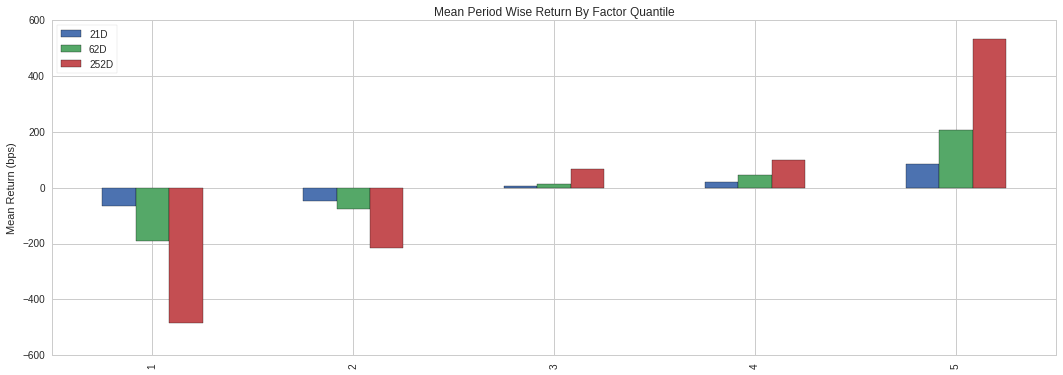

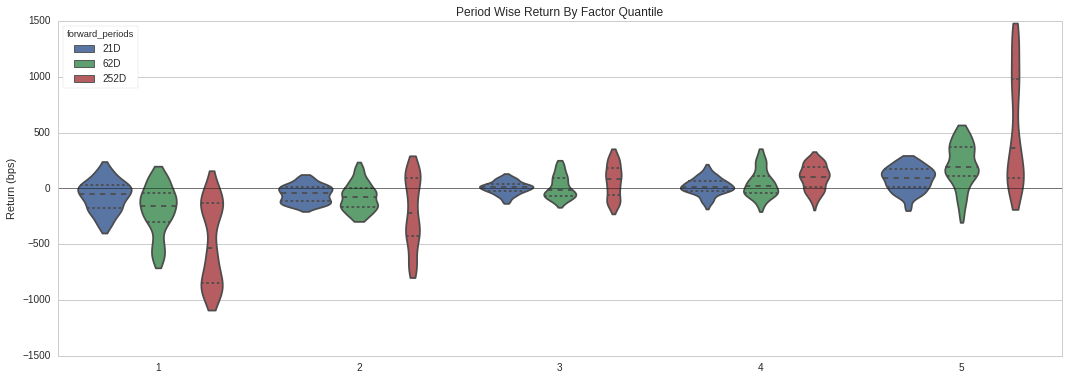

In [17]:

col_name = ["pb_ratio"]
analyze()


************************
************************

ALPHA to examine : pe_ratio
Dropped 16.5% entries from factor data: 16.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.02 secs


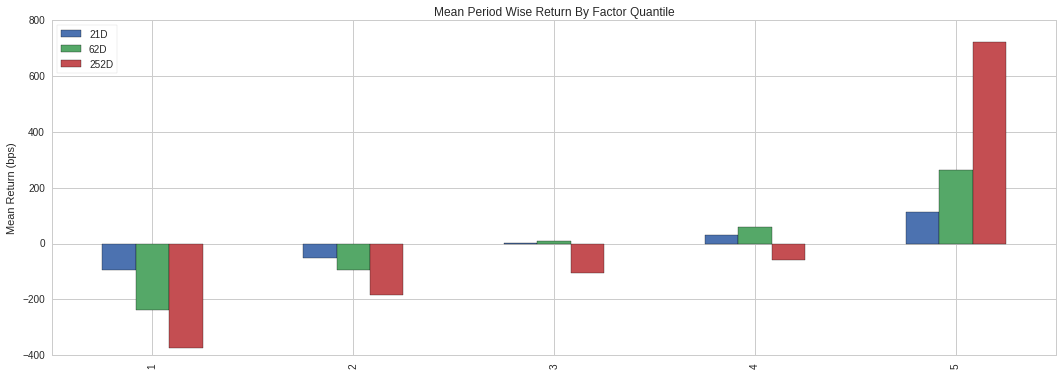

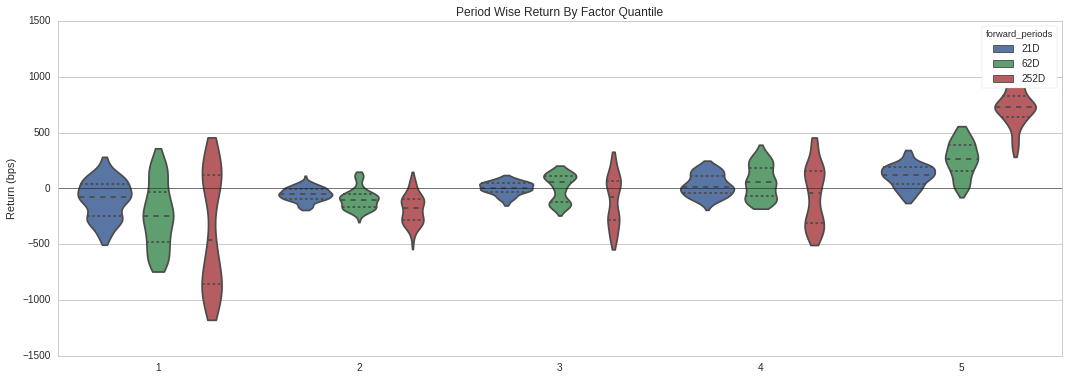

In [18]:
col_name = ["pe_ratio"]
analyze()

In [19]:
col_name = ["peg_ratio"]
analyze()


************************
************************

ALPHA to examine : peg_ratio
Dropped 100.0% entries from factor data: 100.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
!!!!!!! error while analyzing peg_ratio column !!!!!!!!
max_loss (99.9%) exceeded 100.0%, consider increasing it.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



************************
************************

ALPHA to examine : ps_ratio
Dropped 9.0% entries from factor data: 9.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Returns Analysis


21D      62D     252D
Ann. alpha                                       0.112    0.122    0.115
beta                                            -0.088   -0.152   -0.208
Mean Period Wise Return Top Quantile (bps)     114.394  107.217   85.114
Mean Period Wise Return Bottom Quantile (bps)  -87.685  -94.631  -83.458
Mean Period Wise Spread (bps)                  202.080  201.984  168.680

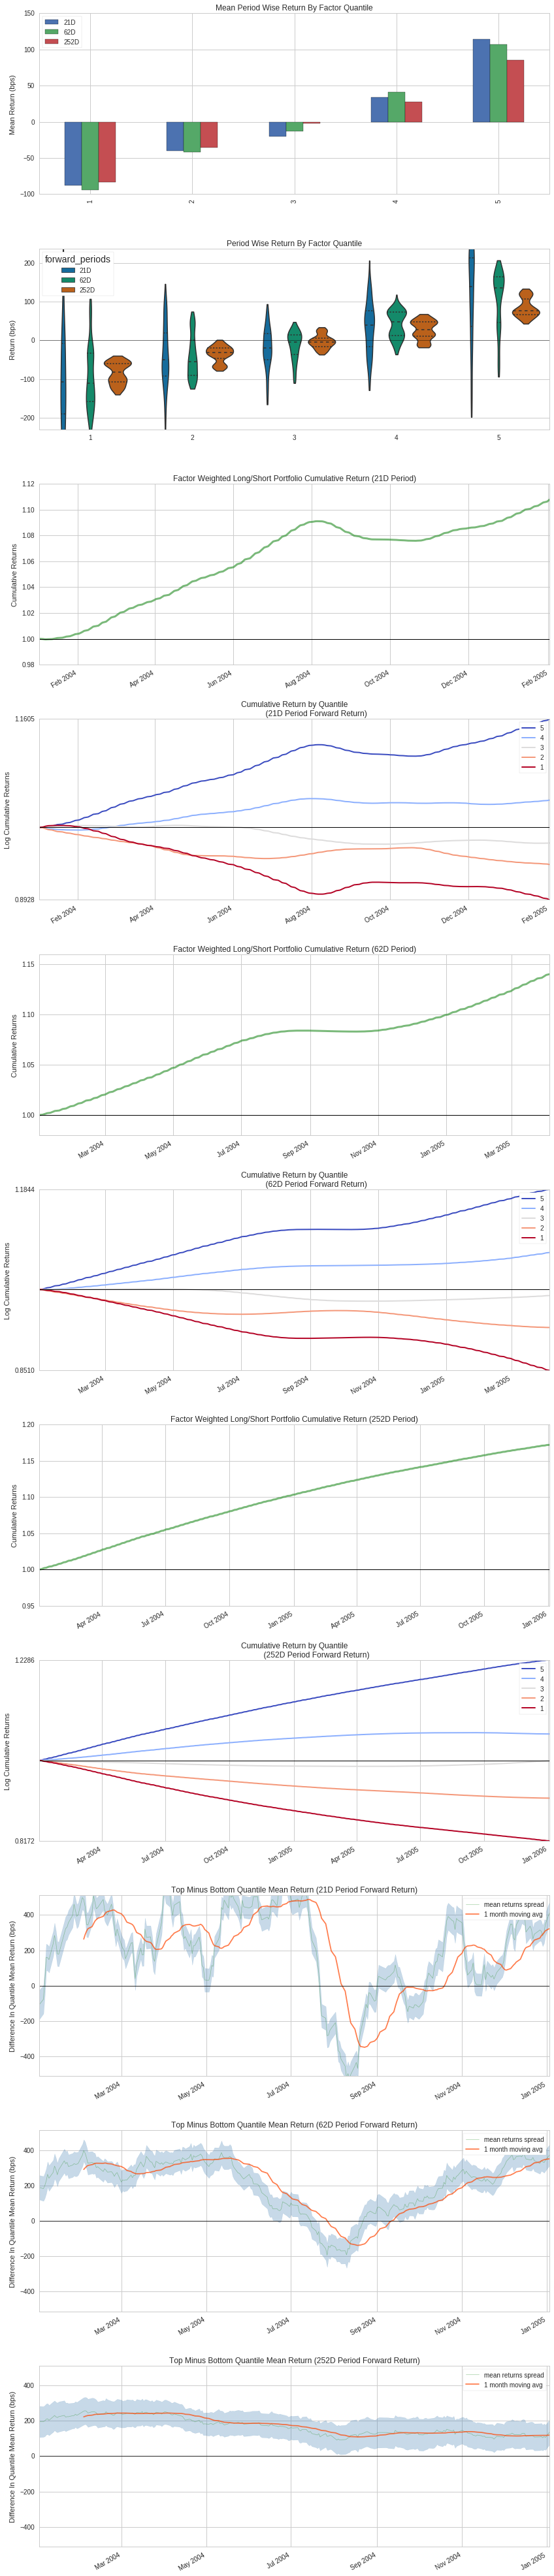

Time to create return tear sheet 134.94 secs


In [20]:
col_name = ["ps_ratio"]
analyze_full()


************************
************************

ALPHA to examine : pcf_ratio
Dropped 14.2% entries from factor data: 14.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.42 secs


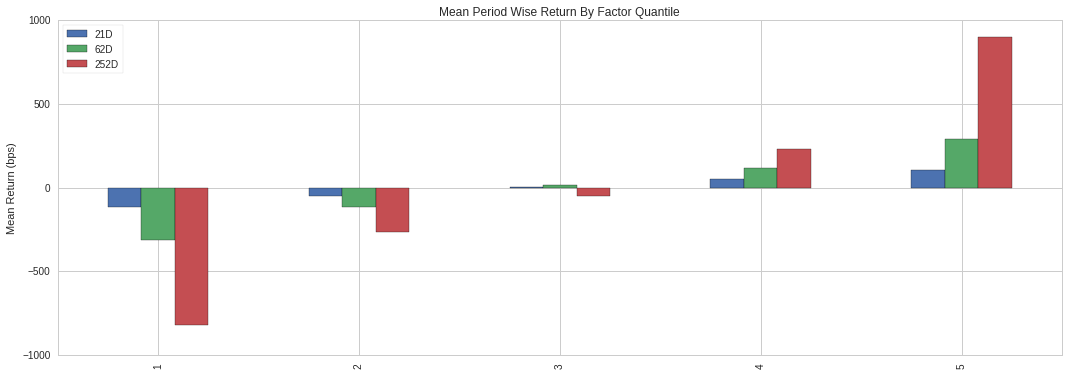

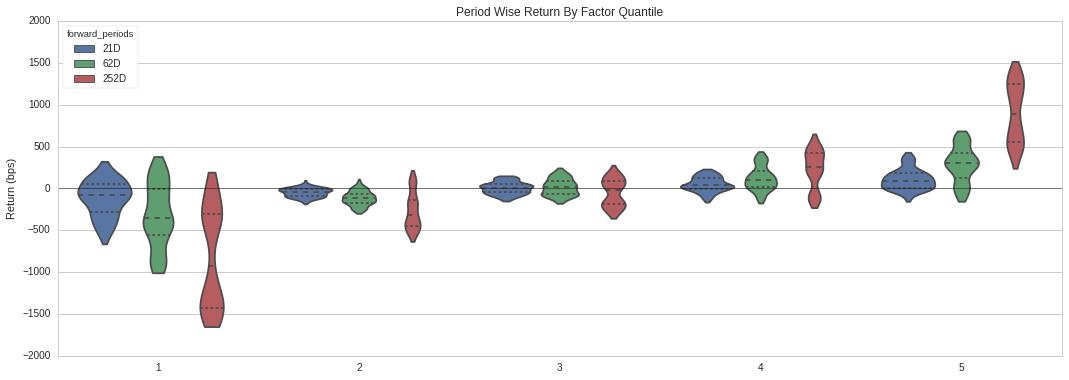

In [21]:
col_name = ["pcf_ratio"]
analyze ()


************************
************************

ALPHA to examine : ev_to_ebitda
Dropped 21.2% entries from factor data: 21.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.19 secs


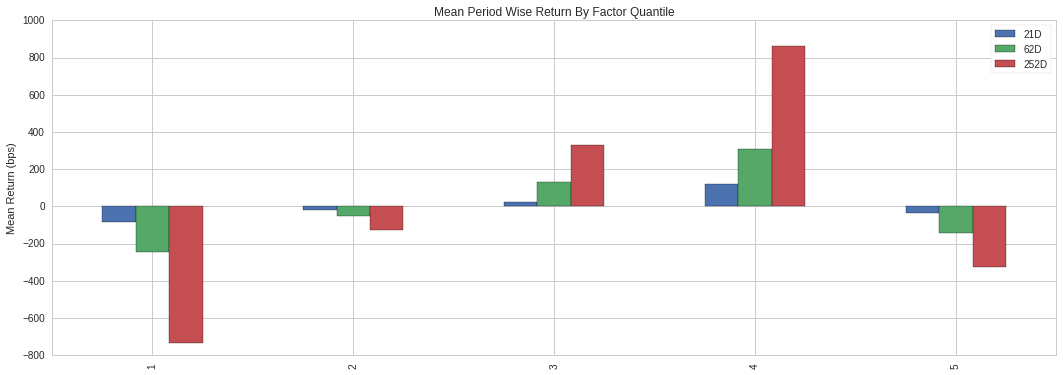

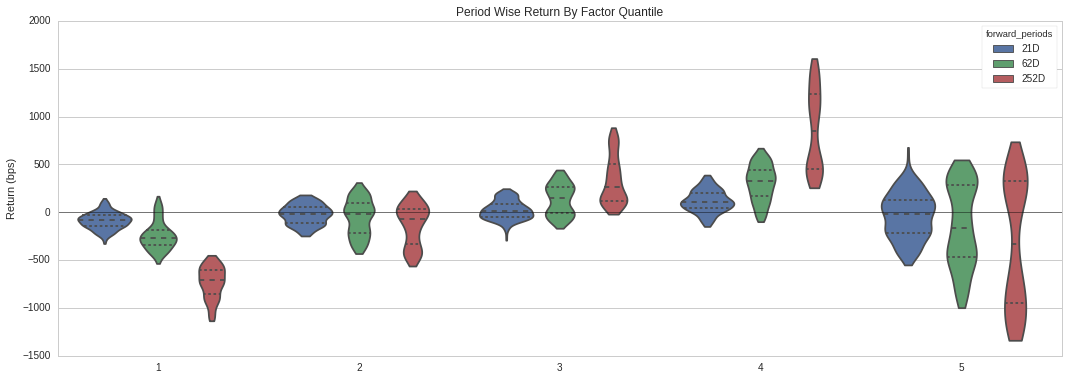

In [22]:
col_name = ["ev_to_ebitda"]
analyze()

In [23]:
col_name = ["value_score"]
analyze()


************************
************************

ALPHA to examine : value_score
Dropped 100.0% entries from factor data: 100.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
!!!!!!! error while analyzing value_score column !!!!!!!!
max_loss (99.9%) exceeded 100.0%, consider increasing it.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



************************
************************

ALPHA to examine : roa
Dropped 8.9% entries from factor data: 8.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.54 secs


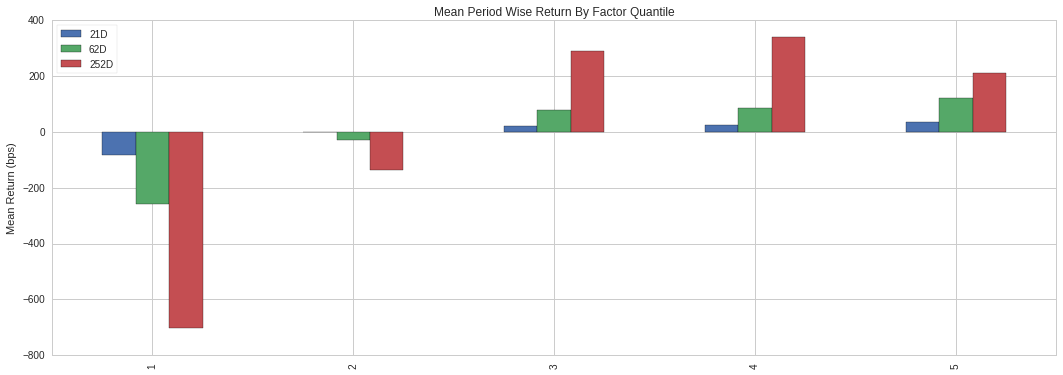

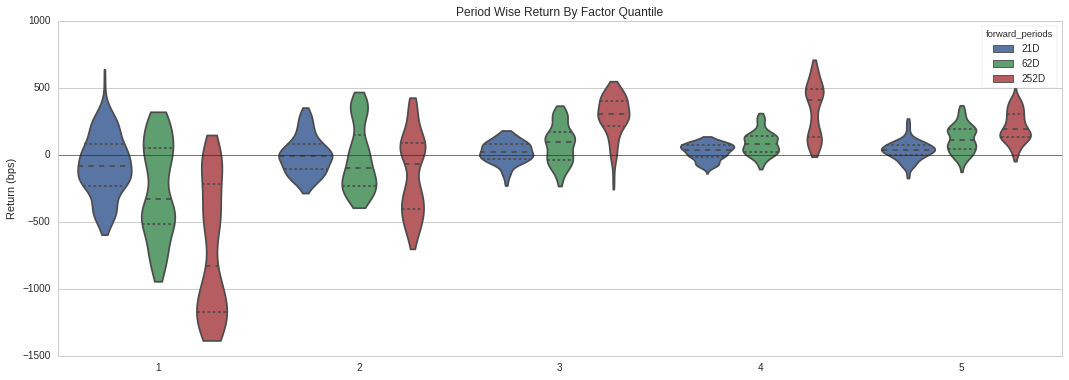

In [24]:
col_name = ["roa"]
analyze()


************************
************************

ALPHA to examine : roe
Dropped 9.5% entries from factor data: 9.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.26 secs


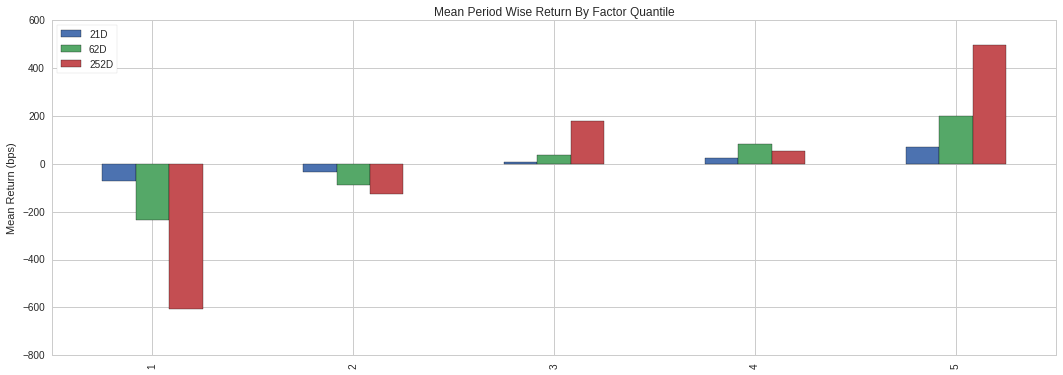

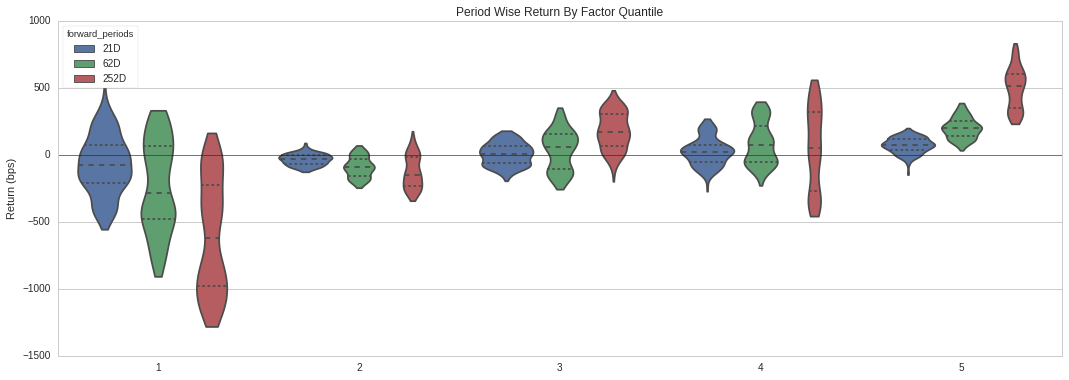

In [25]:
col_name = ["roe"]
analyze()


************************
************************

ALPHA to examine : roic
Dropped 9.4% entries from factor data: 9.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.29 secs


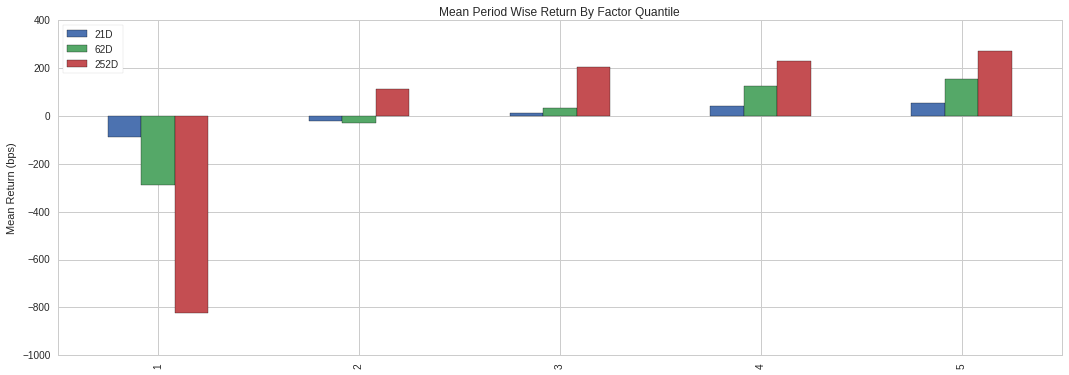

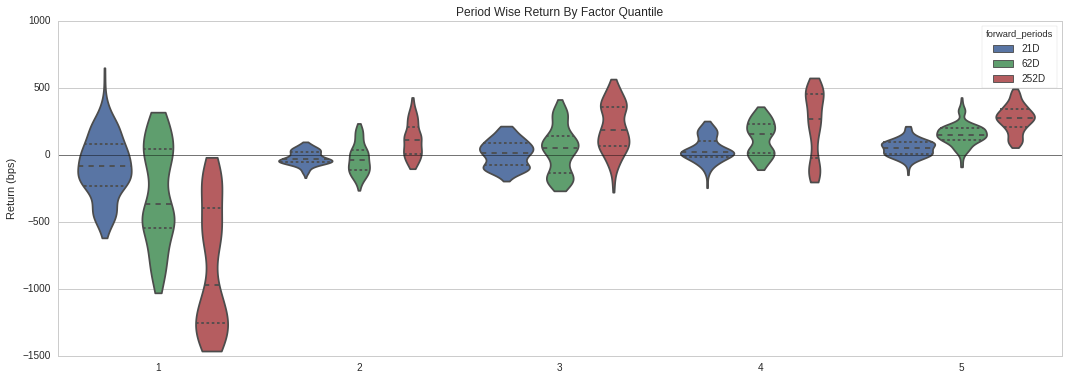

In [26]:
col_name = ["roic"]
analyze()


************************
************************

ALPHA to examine : cash_return
Dropped 13.0% entries from factor data: 13.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.37 secs


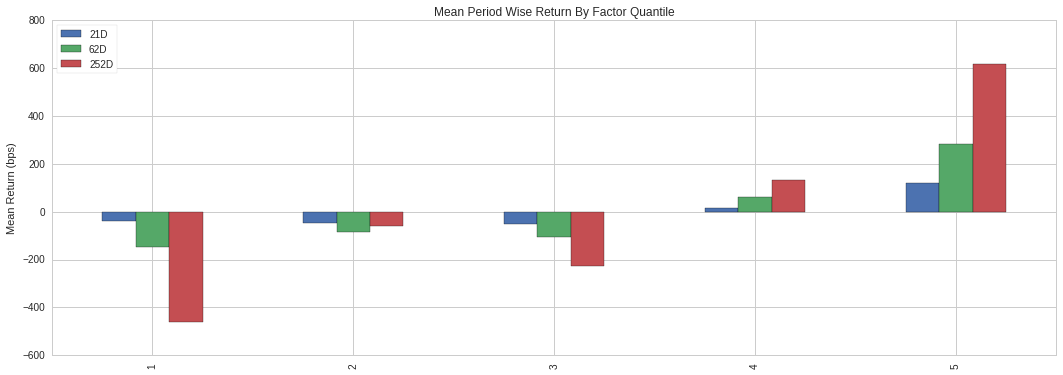

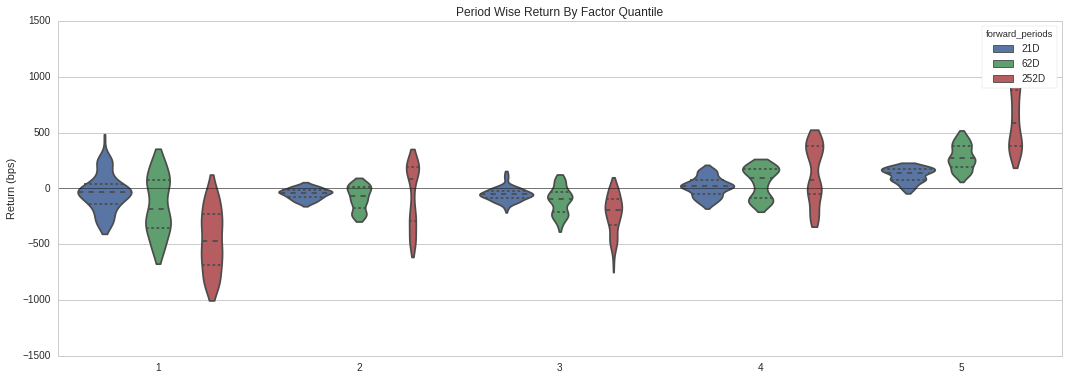

In [27]:
col_name = ["cash_return"]
analyze()


************************
************************

ALPHA to examine : cf_yield
Dropped 8.7% entries from factor data: 8.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.30 secs


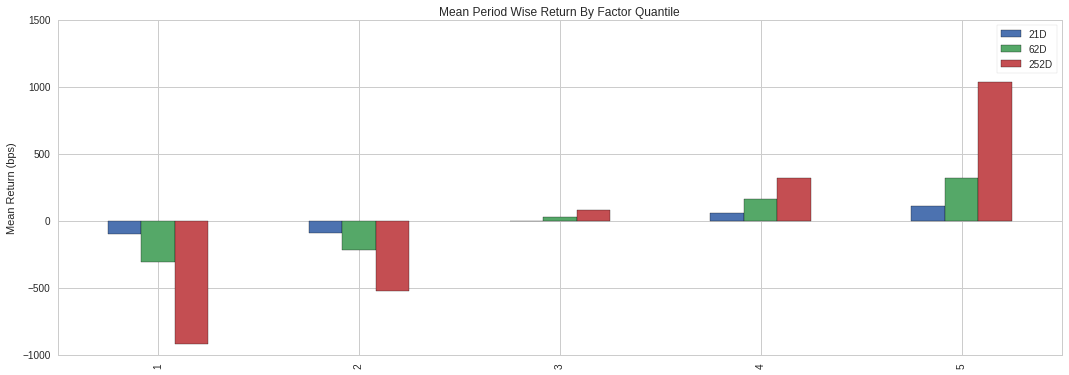

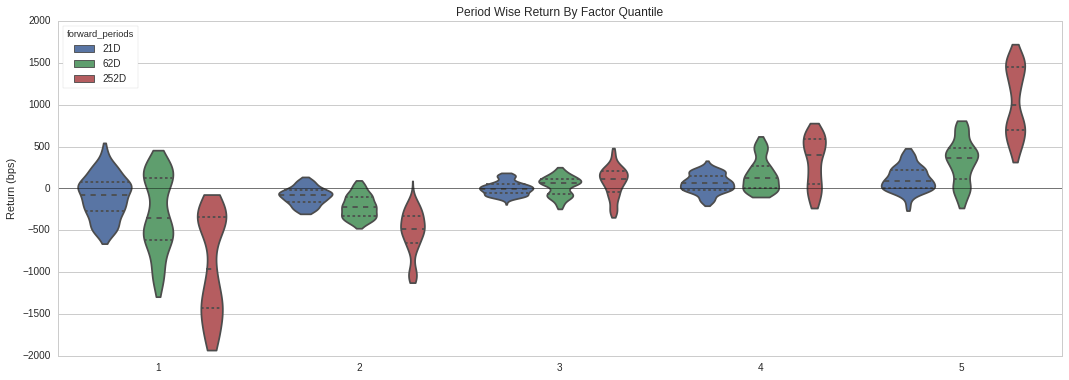

In [28]:
col_name = ["cf_yield"]
analyze()


************************
************************

ALPHA to examine : earning_yield
Dropped 8.7% entries from factor data: 8.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.19 secs


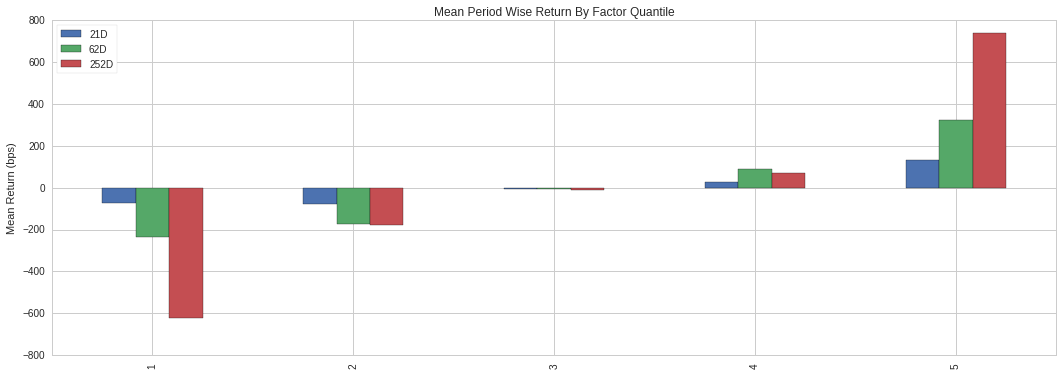

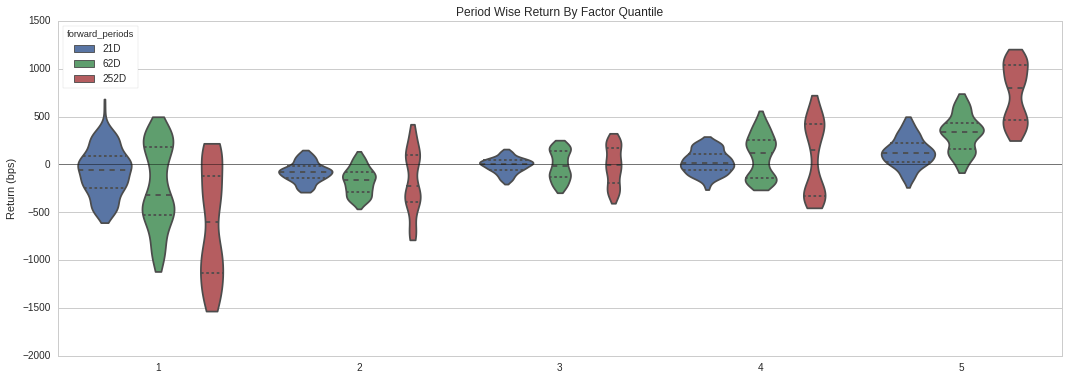

In [29]:
col_name = ["earning_yield"]
analyze()


************************
************************

ALPHA to examine : total_yield
Dropped 44.5% entries from factor data: 44.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 4.76 secs


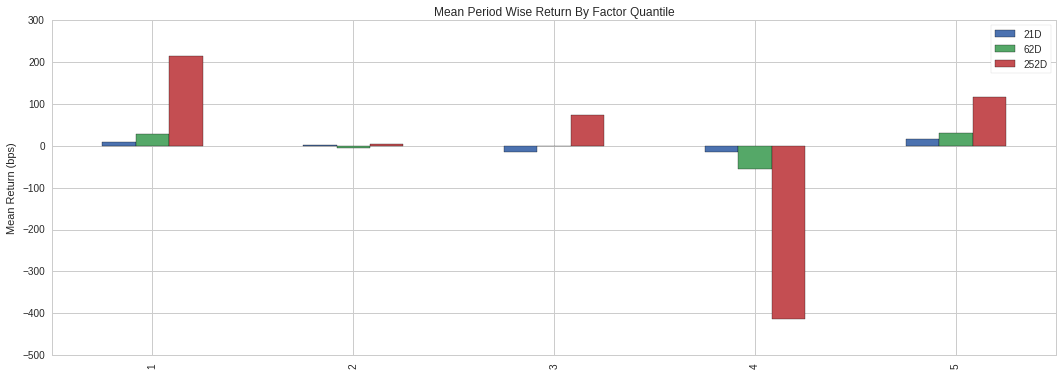

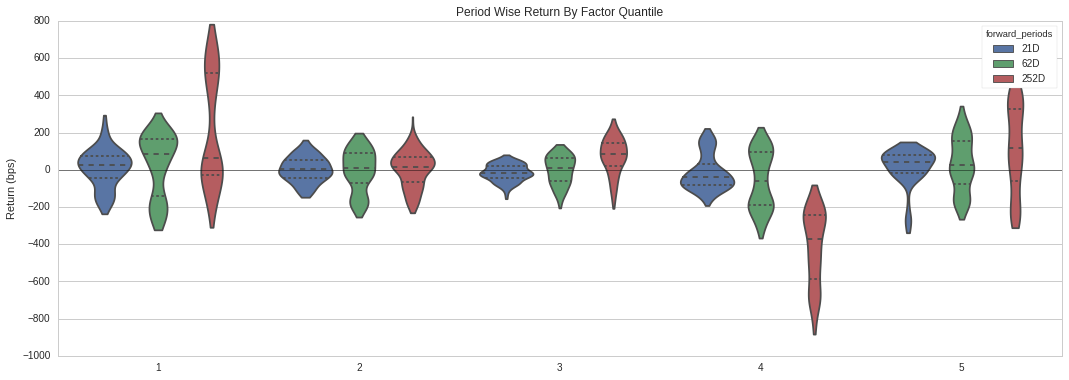

In [30]:
col_name = ["total_yield"]
analyze()


************************
************************

ALPHA to examine : gross_margin
Dropped 26.4% entries from factor data: 26.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 4.84 secs


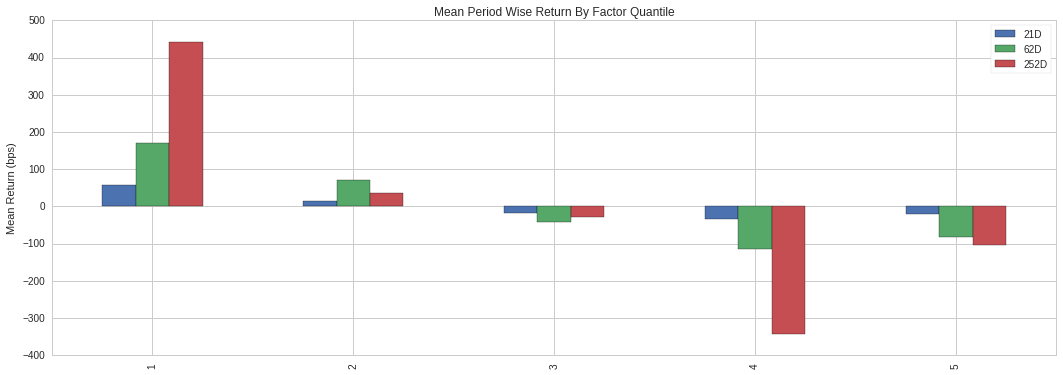

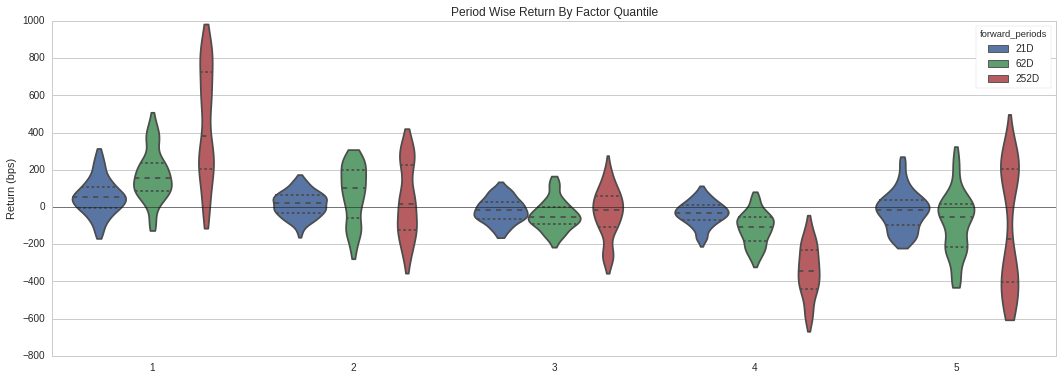

In [31]:
col_name = ["gross_margin"]
analyze()


************************
************************

ALPHA to examine : operation_margin
Dropped 11.6% entries from factor data: 11.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.06 secs


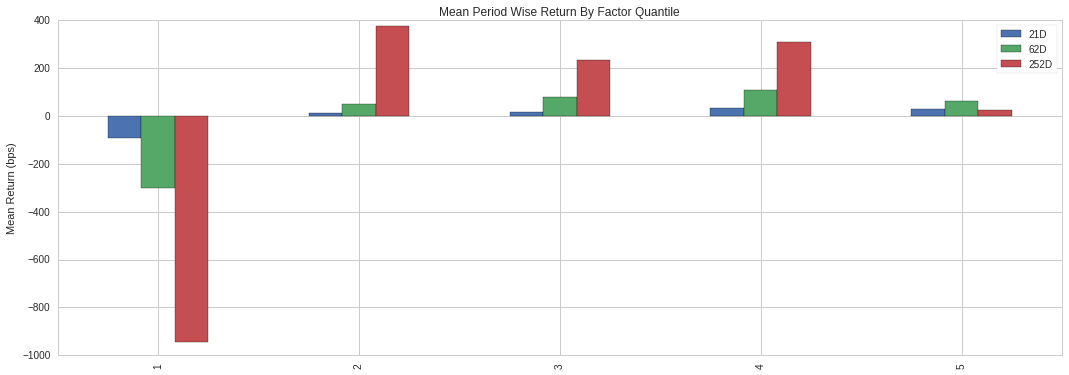

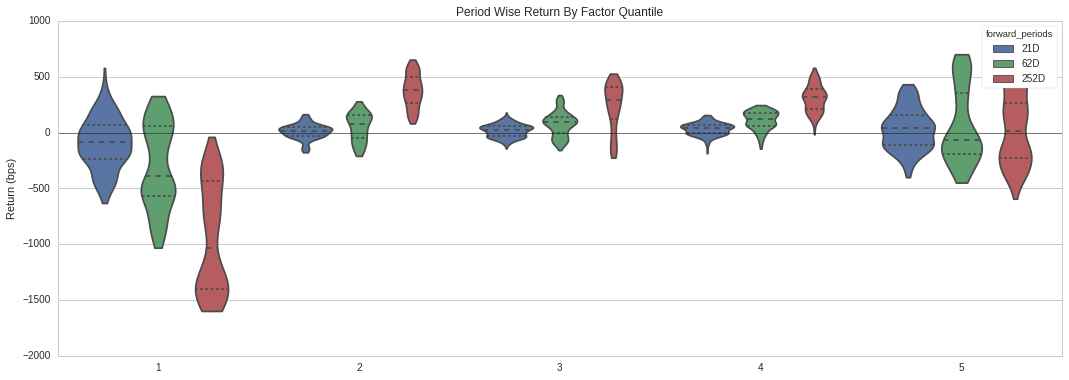

In [32]:
col_name = ["operation_margin"]
analyze()

In [ ]:
col_name = ["ebit_margin"]
analyze()


************************
************************

ALPHA to examine : ebit_margin



************************
************************

ALPHA to examine : net_margin
Dropped 9.1% entries from factor data: 9.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.11 secs


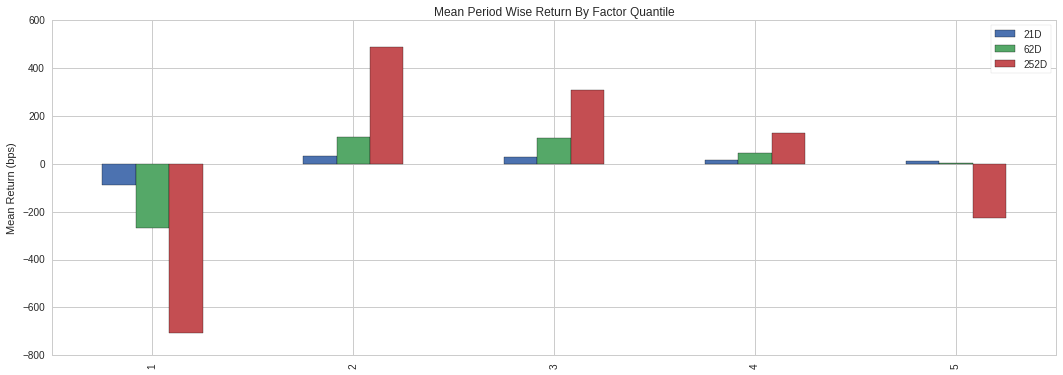

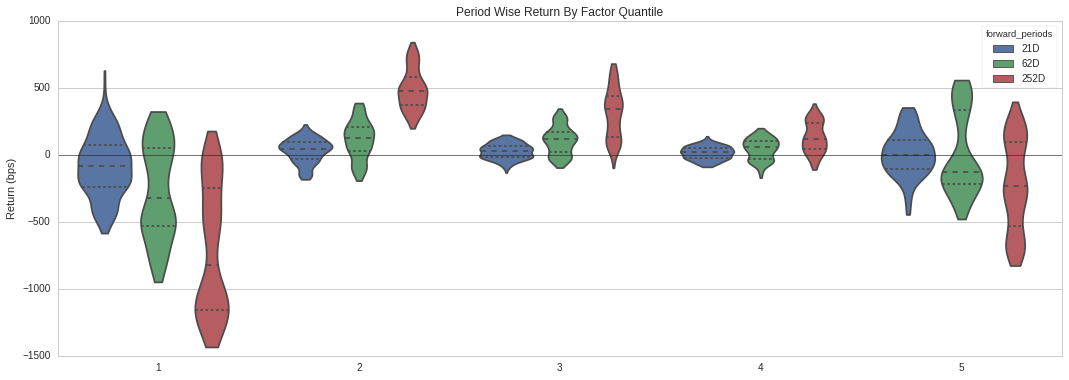

In [56]:
col_name = ["net_margin"]
analyze()


************************
************************

ALPHA to examine : ebit_margin
Dropped 20.4% entries from factor data: 20.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.00 secs


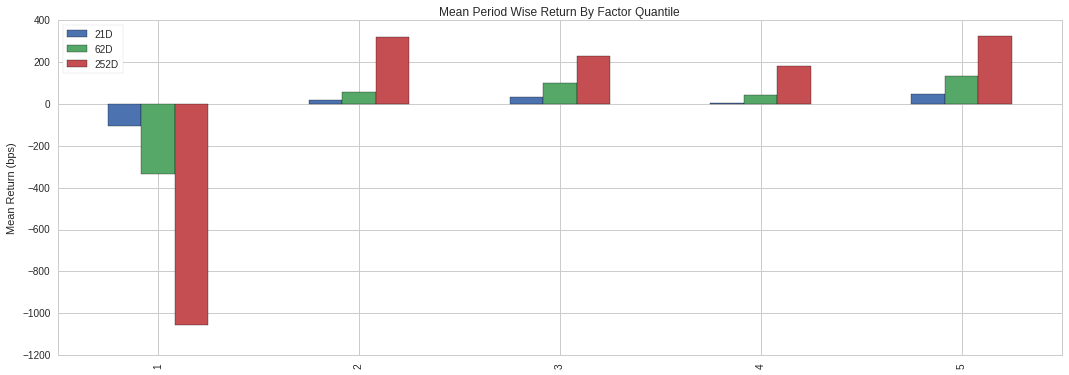

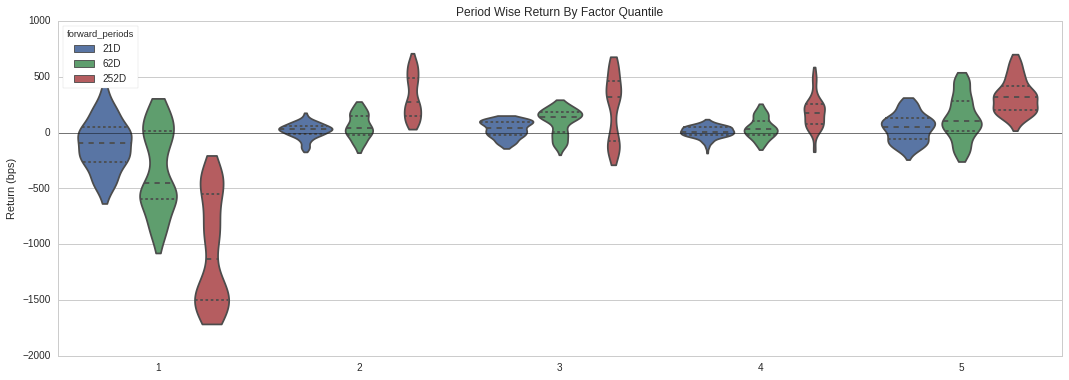

In [57]:
col_name = ["ebit_margin"]
analyze()


************************
************************

ALPHA to examine : revenue_growth
Dropped 9.1% entries from factor data: 9.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Returns Analysis


21D     62D    252D
Ann. alpha                                      0.005   0.015   0.009
beta                                            0.102   0.093   0.080
Mean Period Wise Return Top Quantile (bps)      7.239  17.770  14.611
Mean Period Wise Return Bottom Quantile (bps) -36.829 -43.087 -30.225
Mean Period Wise Spread (bps)                  44.068  60.557  44.766

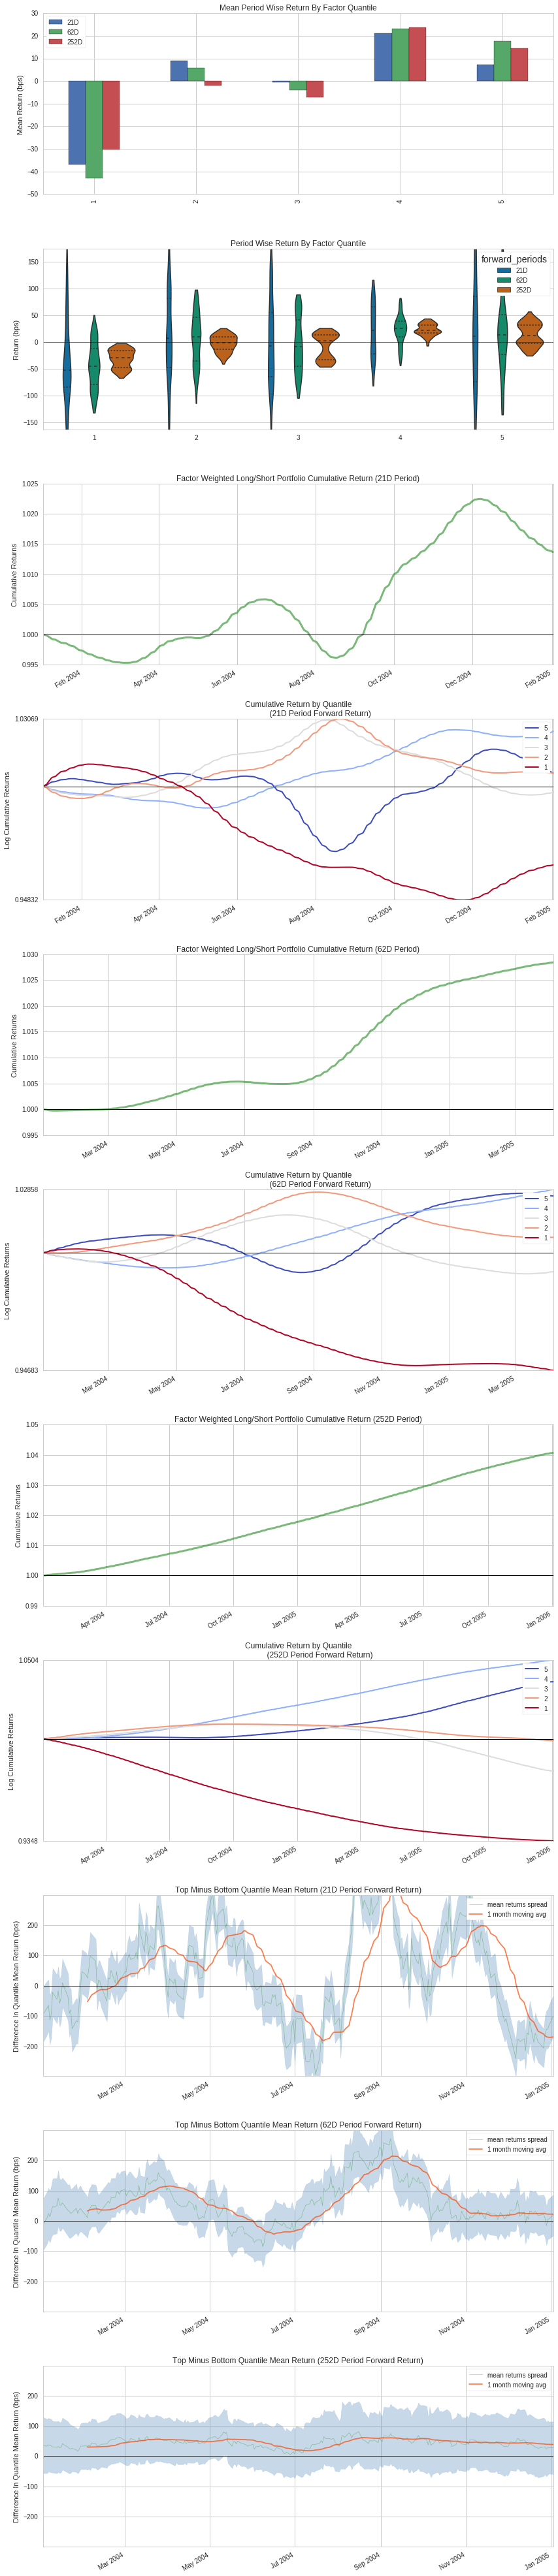

Time to create return tear sheet 132.76 secs


In [58]:
col_name = ["revenue_growth"]
analyze_full()

In [59]:
col_name = ["dps_growth"]
analyze()


************************
************************

ALPHA to examine : dps_growth
Dropped 100.0% entries from factor data: 59.6% in forward returns computation and 40.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
!!!!!!! error while analyzing dps_growth column !!!!!!!!
max_loss (99.9%) exceeded 100.0%, consider increasing it.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



************************
************************

ALPHA to examine : net_income_growth
Dropped 13.8% entries from factor data: 13.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.12 secs


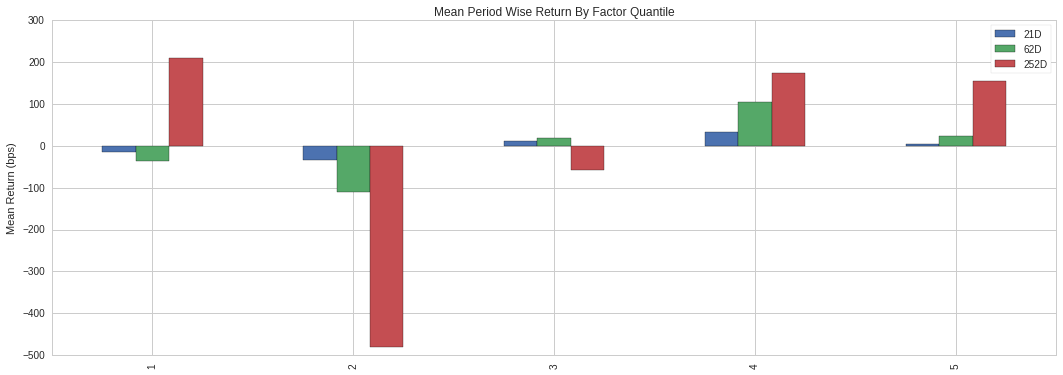

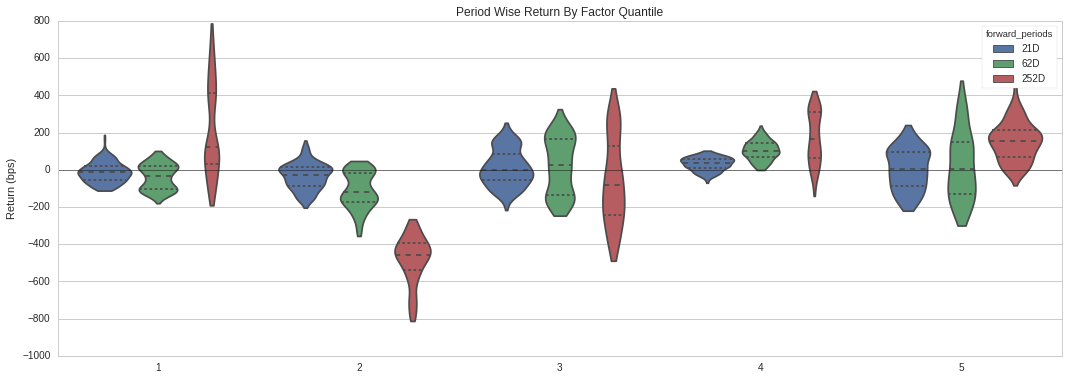

In [60]:
col_name = ["net_income_growth"]
analyze()


************************
************************

ALPHA to examine : sales_per_employee
Dropped 11.1% entries from factor data: 11.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.17 secs


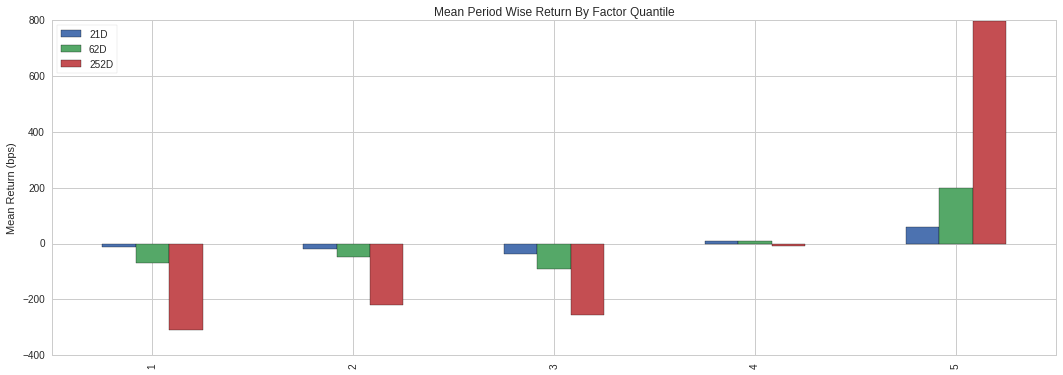

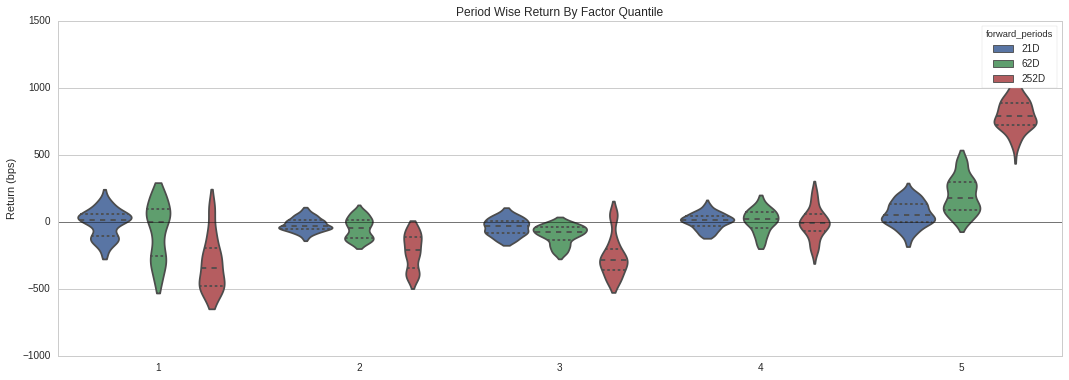

In [61]:
col_name = ["sales_per_employee"]
analyze()

In [62]:
col_name = ["growth_score"]
analyze()


************************
************************

ALPHA to examine : growth_score
Dropped 100.0% entries from factor data: 100.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
!!!!!!! error while analyzing growth_score column !!!!!!!!
max_loss (99.9%) exceeded 100.0%, consider increasing it.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



************************
************************

ALPHA to examine : ltbe_ratio
Dropped 15.6% entries from factor data: 15.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.19 secs


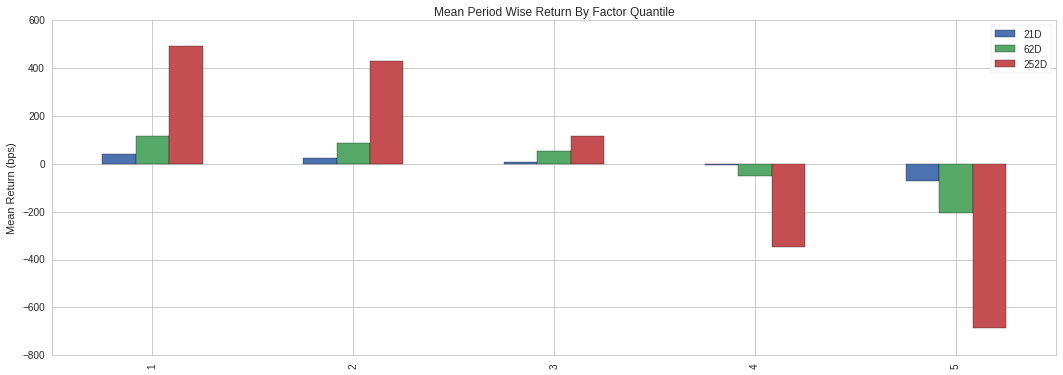

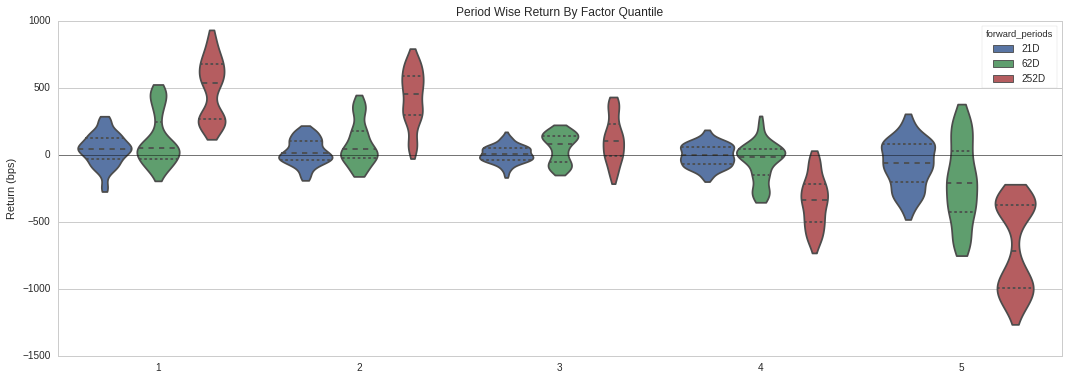

In [63]:
col_name = ["ltbe_ratio"]
analyze()


************************
************************

ALPHA to examine : current_ratio
Dropped 26.1% entries from factor data: 26.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 4.97 secs


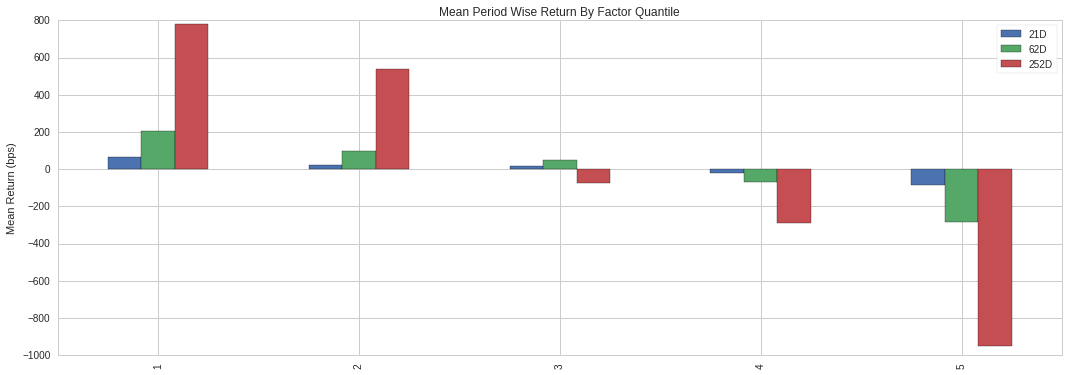

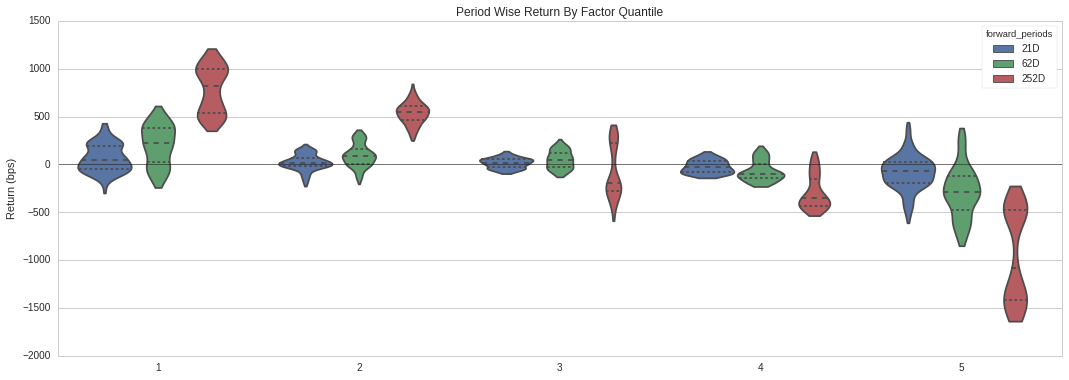

In [64]:
col_name = ["current_ratio"]
analyze()

In [65]:
col_name = ["interest_coverage"]
analyze()


************************
************************

ALPHA to examine : interest_coverage
Dropped 99.9% entries from factor data: 99.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
!!!!!!! error while analyzing interest_coverage column !!!!!!!!
max_loss (99.9%) exceeded 99.9%, consider increasing it.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



************************
************************

ALPHA to examine : assets_turnover
Dropped 9.2% entries from factor data: 9.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.17 secs


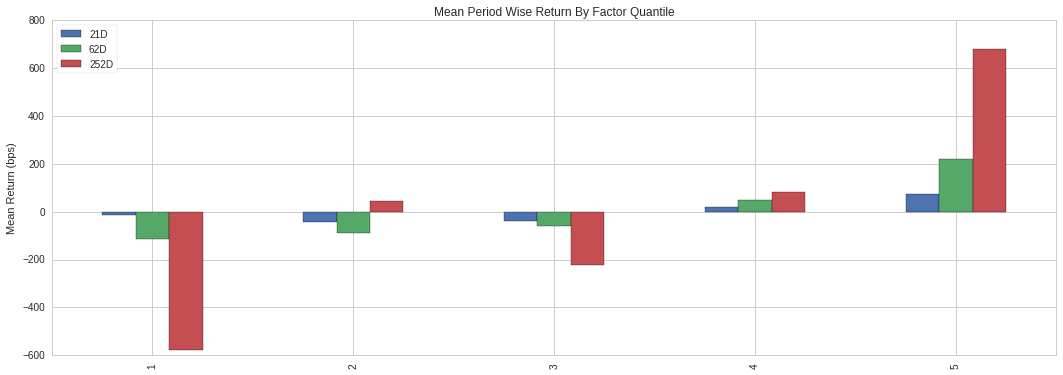

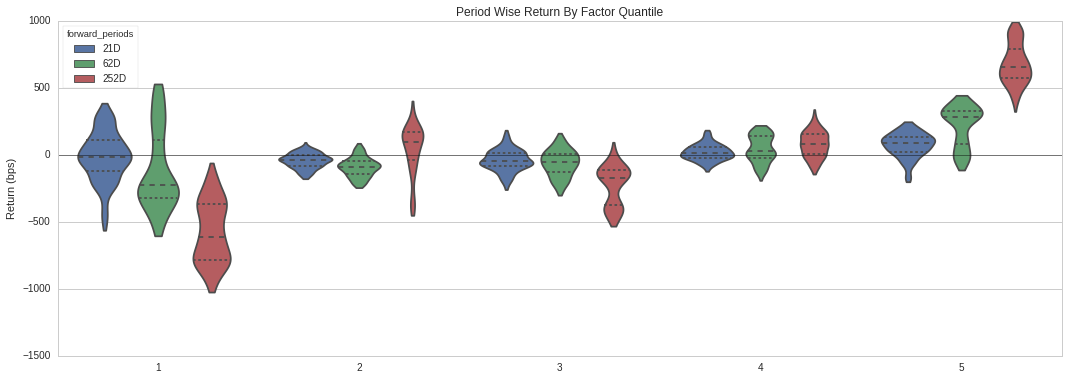

In [66]:
col_name = ["assets_turnover"]
analyze()


************************
************************

ALPHA to examine : cash_conversion_cycle
Dropped 40.7% entries from factor data: 40.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 4.85 secs


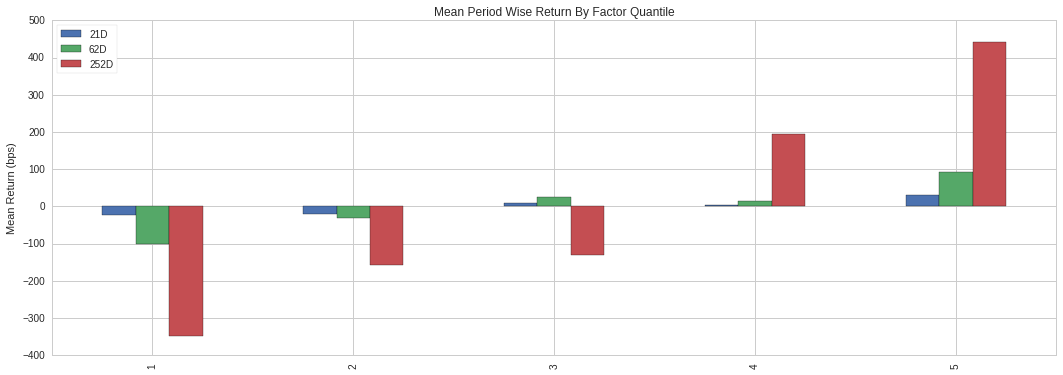

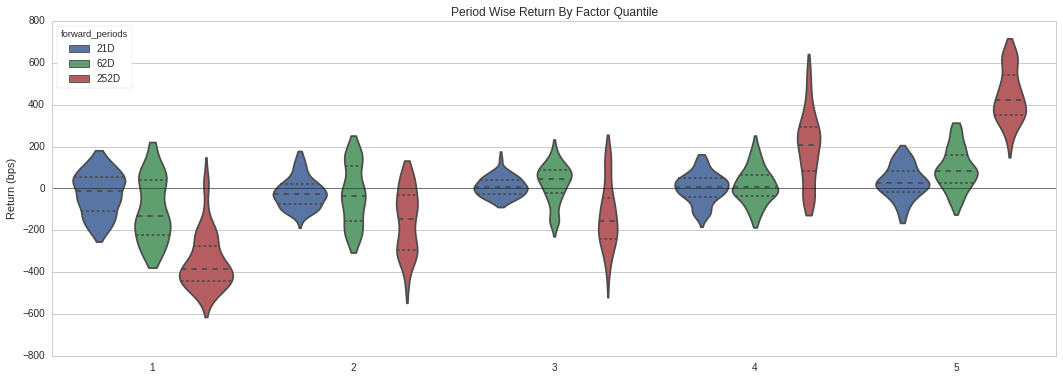

In [67]:
col_name = ["cash_conversion_cycle"]
analyze()


************************
************************

ALPHA to examine : days_in_sales
Dropped 24.4% entries from factor data: 24.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.07 secs


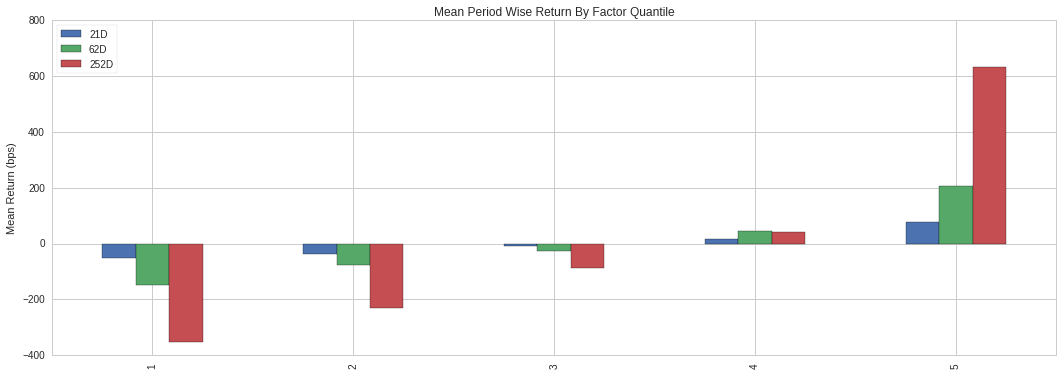

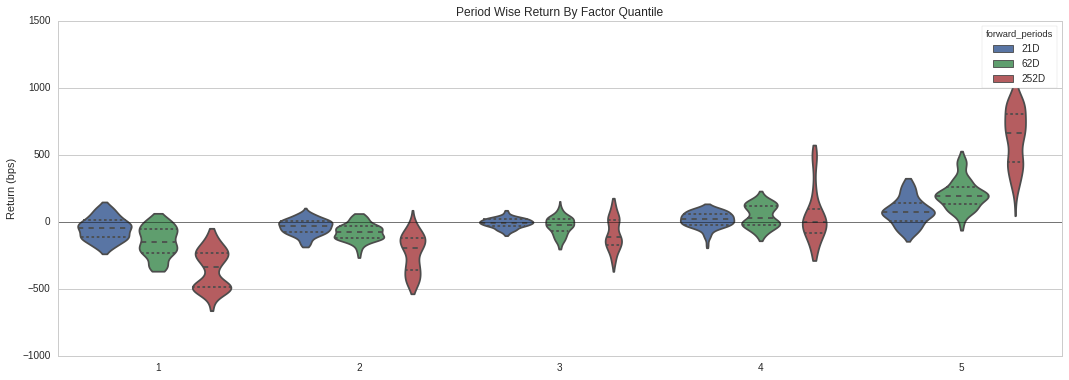

In [68]:
col_name = ["days_in_sales"]
analyze()


************************
************************

ALPHA to examine : market_cap
Dropped 8.6% entries from factor data: 8.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.23 secs


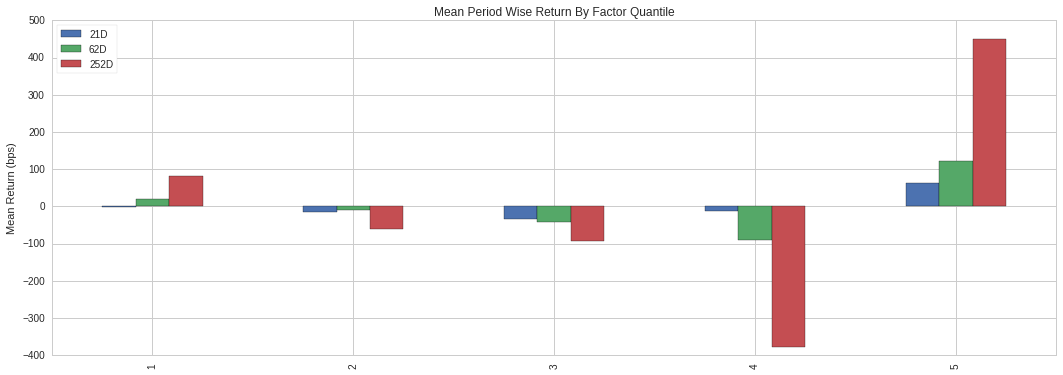

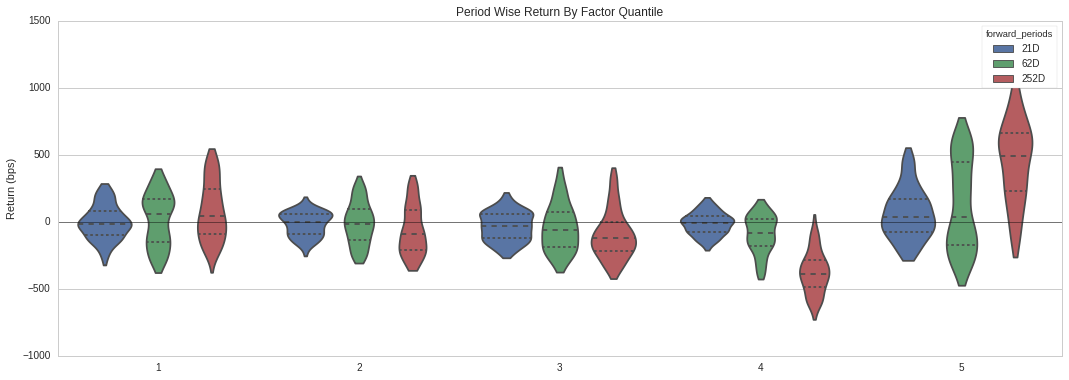

In [69]:
col_name = ["market_cap"]
analyze()

In [70]:
col_name = ["altman_z"]
analyze()


************************
************************

ALPHA to examine : altman_z
Dropped 100.0% entries from factor data: 100.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
!!!!!!! error while analyzing altman_z column !!!!!!!!
max_loss (99.9%) exceeded 100.0%, consider increasing it.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



************************
************************

ALPHA to examine : mom_test_1
Dropped 14.8% entries from factor data: 14.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.19 secs


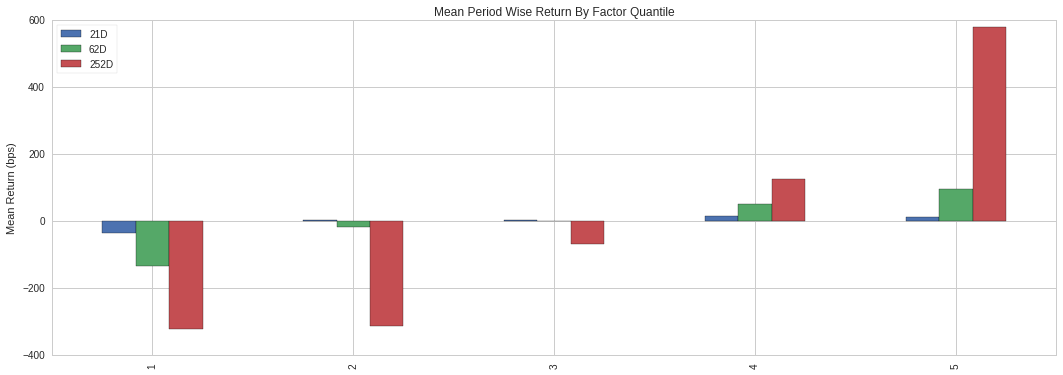

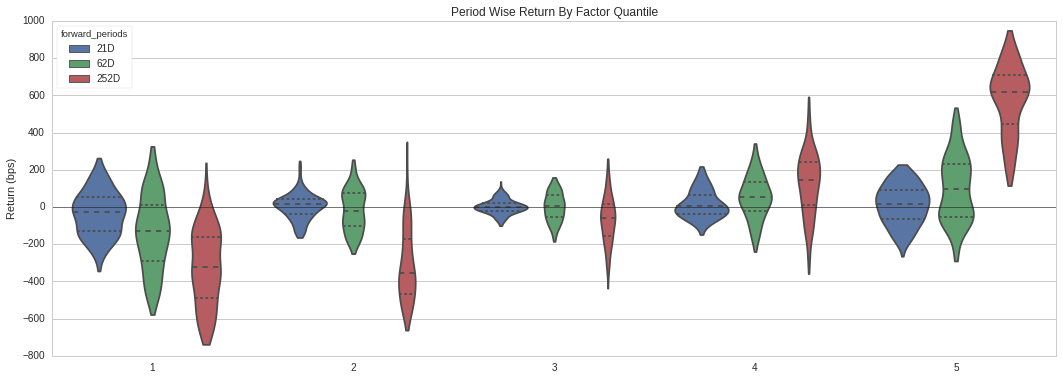

In [71]:
col_name = ["mom_test_1"]
analyze()


************************
************************

ALPHA to examine : mom_test_2
Dropped 12.5% entries from factor data: 12.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.13 secs


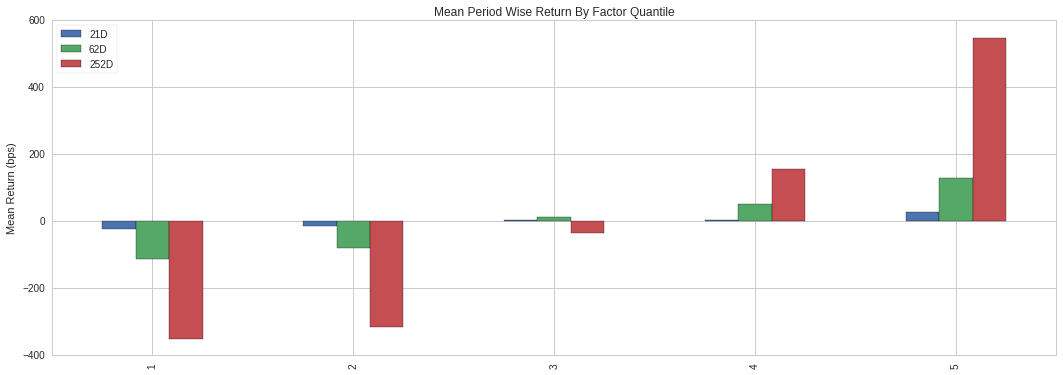

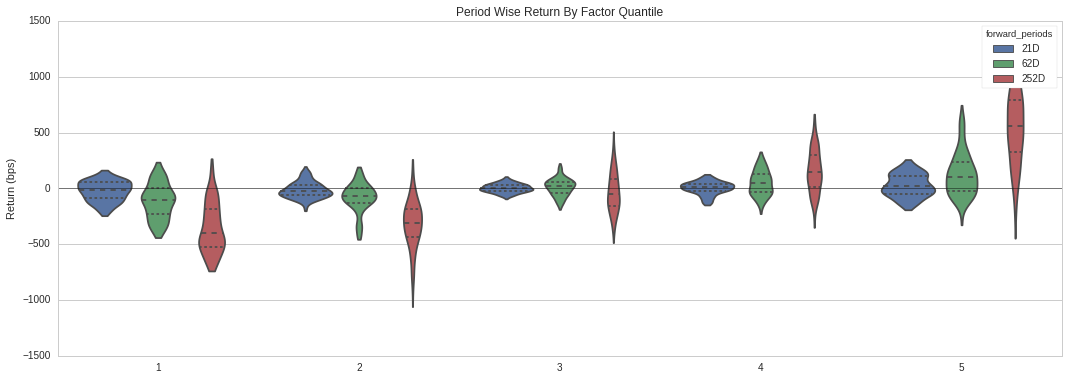

In [72]:
col_name = ["mom_test_2"]
analyze()


************************
************************

ALPHA to examine : mom_test_3
Dropped 11.1% entries from factor data: 11.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.16 secs


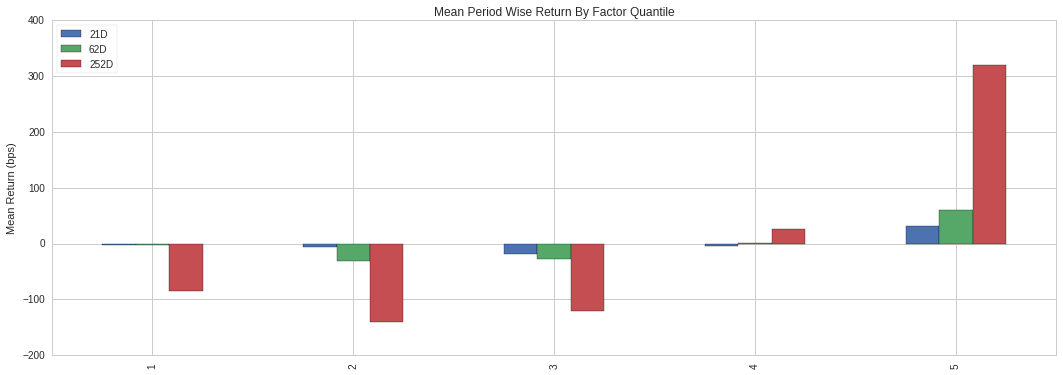

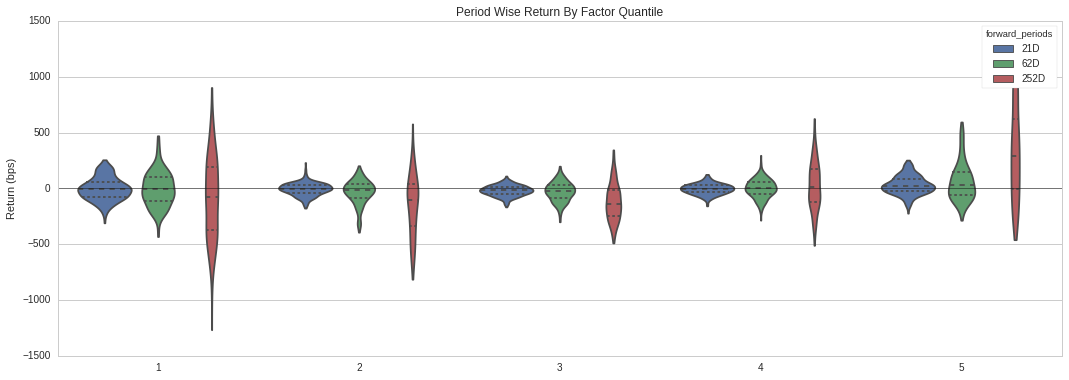

In [73]:
col_name = ["mom_test_3"]
analyze()


************************
************************

ALPHA to examine : price_mom_M
Dropped 9.5% entries from factor data: 9.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.17 secs


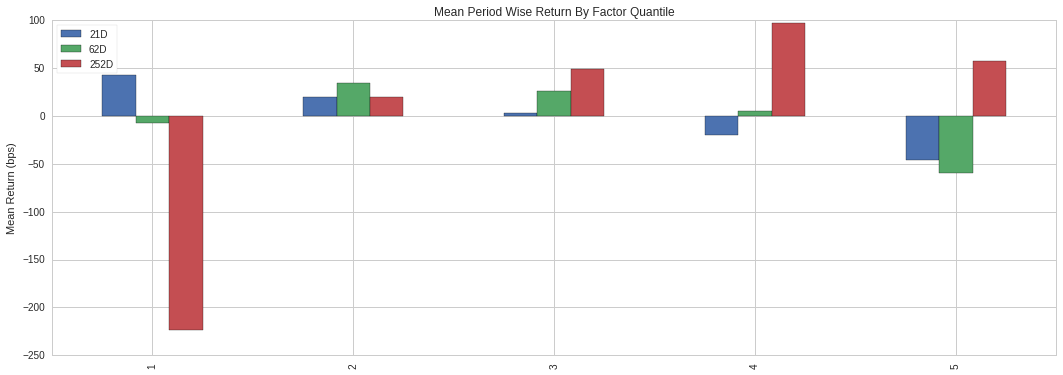

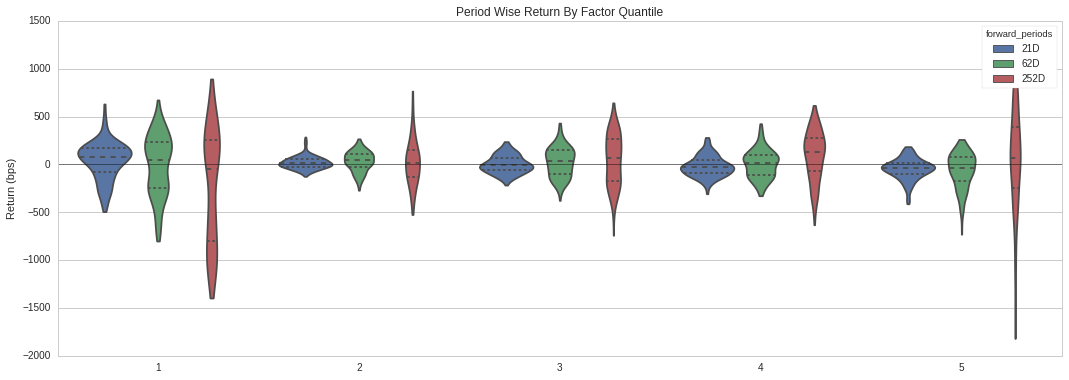

In [74]:
col_name = ["price_mom_M"]
analyze()


************************
************************

ALPHA to examine : price_mom_Q
Dropped 10.6% entries from factor data: 10.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.17 secs


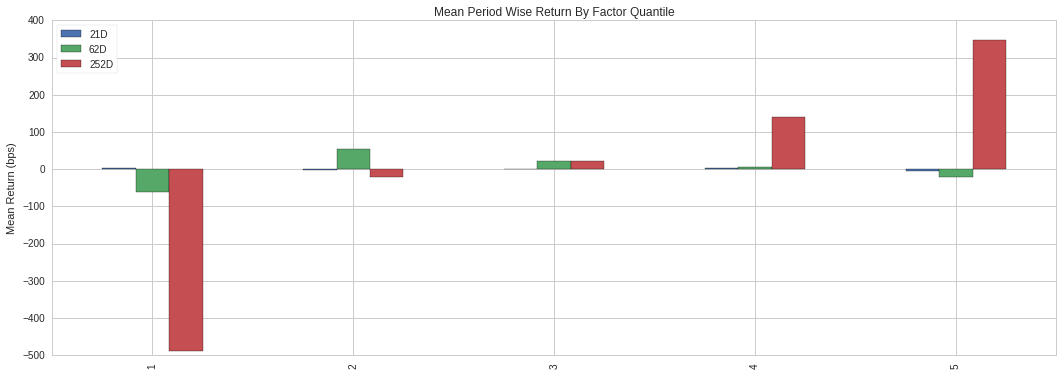

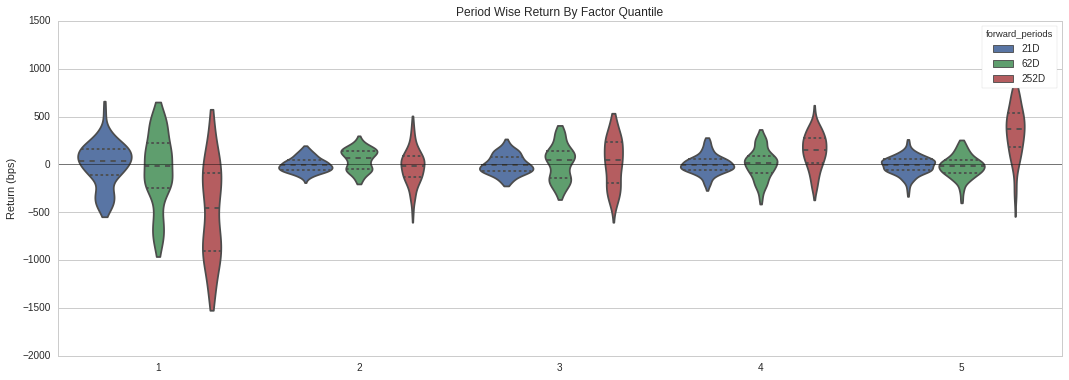

In [75]:
col_name = ["price_mom_Q"]
analyze()


************************
************************

ALPHA to examine : price_mom_H
Dropped 12.0% entries from factor data: 12.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.15 secs


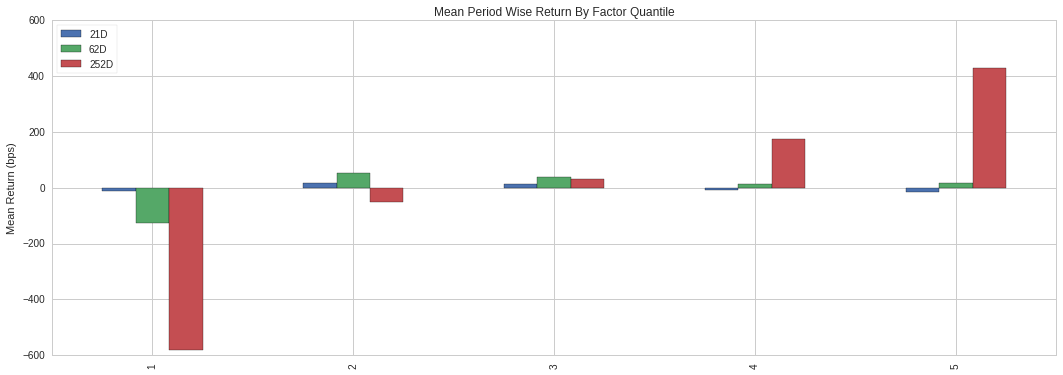

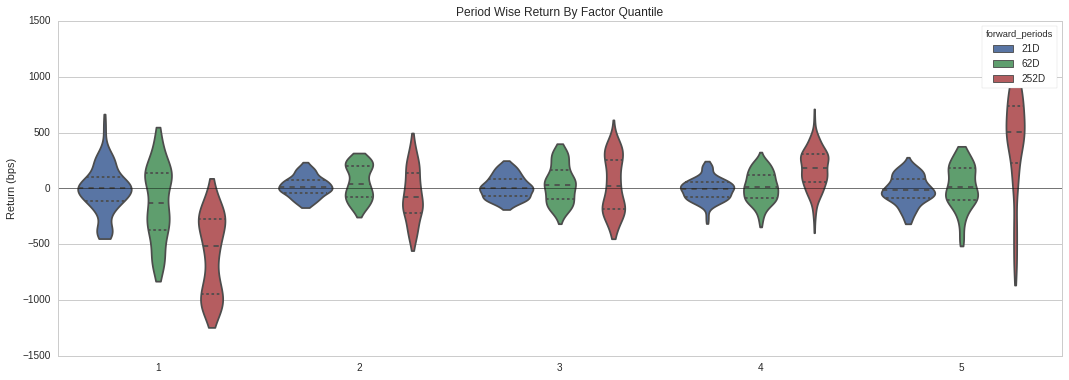

In [76]:
col_name = ["price_mom_H"]
analyze()


************************
************************

ALPHA to examine : price_mom_Y
Dropped 14.3% entries from factor data: 14.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.9%, not exceeded: OK!
Time to create return tear sheet 5.11 secs


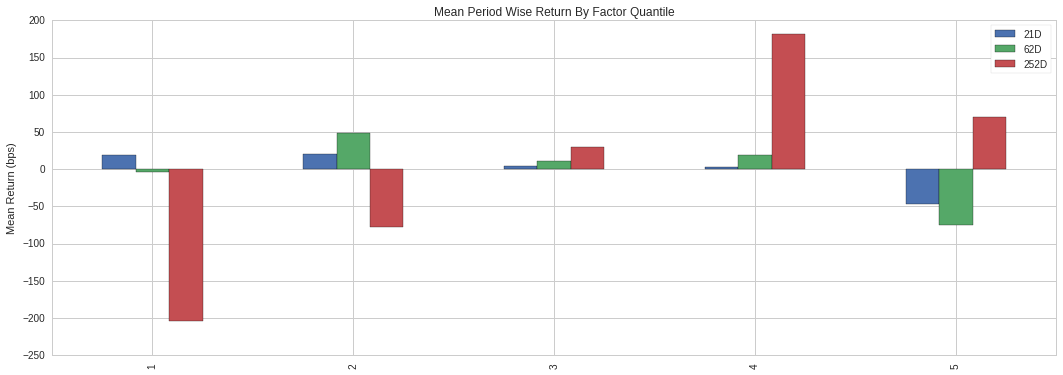

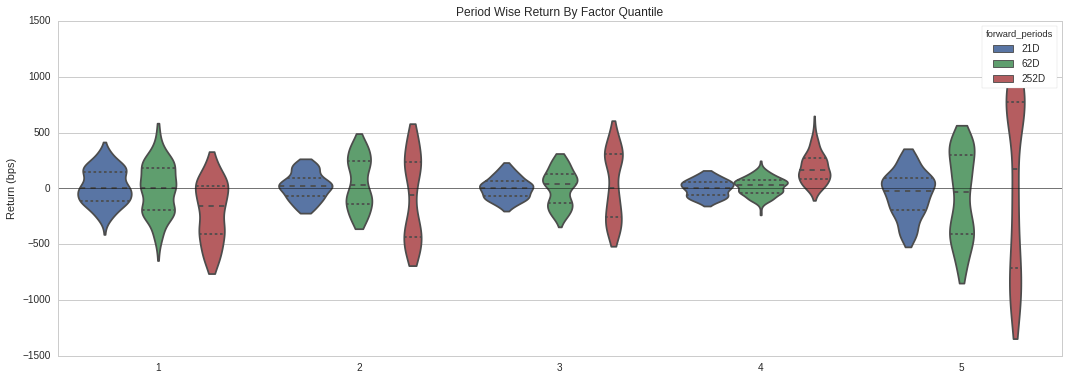

In [77]:
col_name = ["price_mom_Y"]
analyze()